### `clustering_3.ipynb`

Last updated: 11/15/23

Using unap, exactly `clustering_02.ipynb``

In [1]:
## Import packages and modules
import os
import sys

main_path = "/Genomics/argo/users/tt1131/dp_vq_code/"

sys.path.append(main_path)
sys.path.append(os.path.join(main_path, "expts/fly/"))

import numpy as np
from einops import rearrange

from base.utils import *
from data_module_re import *
from deep_phase_re import *  

from pytorch_lightning import seed_everything

import umap
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from matplotlib import cm 
import seaborn as sns

## Set random seed
seed = 42
seed_everything(seed, workers=True)
rs = np.random.RandomState(seed)

states_c_dict = {
    1: cm.tab20c(4),
    2: cm.tab20c(5),
    7: cm.tab20c(0), 
    9: cm.tab20c(1), 
    10: cm.tab20c(2),
    16: cm.tab20c(8),
    18: cm.tab20c(12),
}

In [ ]:
fig_path = "/Genomics/argo/users/tt1131/dp_vq_code/figures/"

In [ ]:
def butter_pass(pass_type, data, cutoff, fs, order, axis = 0):
    from scipy.signal import butter, filtfilt
    
    b, a = butter(order, cutoff / (fs * .5), btype=pass_type, analog=False)
    joints_pass = []
    for idx, seg in enumerate(data):
        joints_pass.append(filtfilt(b, a, seg, axis = axis))
    return np.array(joints_pass, dtype=object)

## Dataset Parameters
intvl_size = 1
fs = 100
cutoff = 1
order = 3
num_workers = 10
test_size = .2

epochs = 40
num_joints = 62
in_channels = num_joints
out_channels = num_joints // 2

## Model Parameters
window_size = 39
lr = 1e-4
batch_size = 32
latent_channels = 1

## States and Joints
joints_seg = np.load(
    os.path.join(main_path, "expts/datasets/fly/joints_102723.npy"),
    allow_pickle=True,
)
states = np.load(
    os.path.join(main_path, "expts/datasets/fly/states_102723.npy"),
    allow_pickle=True,
)

lc_hp_joints = butter_pass("hp", joints_seg, cutoff = cutoff, 
                            fs = fs, order = order, axis = 0)

dm = dp_dm(
    lc_hp_joints,
    states,
    batch_size,
    window_size,
    intvl_size,
    num_workers,
    test_size,
    rs
)
dm.setup()

In [ ]:
from pathlib import Path
num_channels = 8
model_path = list(Path(f"/Genomics/argo/users/tt1131/dp_vq_code/expts_wandb/fly-231028/expt-{num_channels}").glob("*"))[0].as_posix()
model = deep_phase.load_from_checkpoint(model_path)
model.freeze()

val_trainer = pl.Trainer(
    enable_progress_bar = True,
    deterministic = True,
    accelerator = 'gpu', 
    devices = -1
)

val_predicted = val_trainer.predict(model, dm.val_dataloader())

/Genomics/argo/users/tt1131/miniconda3/envs/deepphase/lib/python3.8/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /Genomics/argo/users/tt1131/miniconda3/envs/deepphas ...
  rank_zero_warn(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Genomics/argo/users/tt1131/miniconda3/envs/deepphase/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
/Genomics/argo/users/tt1131/miniconda3/envs/deepphase/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarnin

Predicting: 0it [00:00, ?it/s]

In [ ]:
out_list = []

out_dict = {
    "input": [], "latents": [], "recr": [], "L": [],
    "f": [], "a": [], "b": [], "s": [],
    "state": [], "m": []
}
    
for items in val_predicted:
    for key, i in zip(list(out_dict.keys()), items):
        out_dict[key].append(i.detach().cpu().numpy())

for key, item in out_dict.items():
    out_dict[key] = np.concatenate(item).squeeze()
    print(key, out_dict[key].shape)

input (16135, 39, 62)
latents (16135, 8, 39)
recr (16135, 39, 62)
L (16135, 8, 39)
f (16135, 8)
a (16135, 8)
b (16135, 8)
s (16135, 8)
state (16135,)
m (16135, 8, 20)


In [ ]:
def rephase(f, a, p, b, tpi, args):
    ## To scale everything to 0, negative of original phase
    return torch.tensor(a * np.sin(tpi * (f * args)) + b).float()

def rephase_decode(num_channels, f, a, p, b, tpi, args, decoder):
    ## only for one sample
    if num_channels == 1:
        re_p = rephase(f, a, p, b, tpi, args)
        re_p_torch = torch.tensor(re_p).float()
        if len([*re_p_torch]) >= 2:
            re_p_torch = re_p_torch.unsqueeze(1)
        else:
            re_p_torch = re_p_torch.unsqueeze(0).unsqueeze(0)
        return decoder(re_p_torch).detach().cpu().numpy()
    else:
        re_p_all = []
        for nc in range(num_channels):
            re_p = rephase(f[nc], a[nc], p[nc], b[nc], tpi, args)
            re_p_torch = torch.tensor(re_p).float()
            re_p_all.append(re_p_torch[:, np.newaxis])
            
        latent_full = torch.concat(re_p_all, axis = 1).T.unsqueeze(0)
        return latent_full, decoder(latent_full).detach().cpu().numpy()

In [ ]:
tpi = model.tpi.detach().cpu().numpy()
args = model.args.detach().cpu().numpy()

rephased_L = []
rephased_out = []

for f, a, b, s in zip(out_dict['f'], out_dict['a'], out_dict['s'], out_dict['b']):
    rp_L, rp_out = rephase_decode(num_channels, f, a, b, s, tpi, args, model._decoder)
    rephased_L.append(rp_L)
    rephased_out.append(rp_out)

rephased_out = np.stack(rephased_out).squeeze()
rephased_L = np.stack(rephased_L).squeeze()

/tmp/ipykernel_2994138/636191786.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  re_p_torch = torch.tensor(re_p).float()


In [ ]:
input_stacked = rearrange(out_dict['input'], "n t j -> n (t j)")
recr_stacked = rearrange(out_dict['recr'], "n t j -> n (t j)")
reph_stacked = rearrange(rephased_out, "n t j -> n (t j)")

recr_L = rearrange(out_dict["L"], 'n t j -> n (t j)')
reph_L = rearrange(rephased_L, 'n t j -> n (t j)')

In [ ]:
umap_obj = umap.UMAP(n_neighbors = 15, n_components = 2,
                    min_dist = .3, metric = "euclidean")

umap_input = umap_obj.fit_transform(input_stacked)
umap_dp_out = umap_obj.fit_transform(recr_stacked)
umap_dp_rp = umap_obj.fit_transform(reph_stacked)

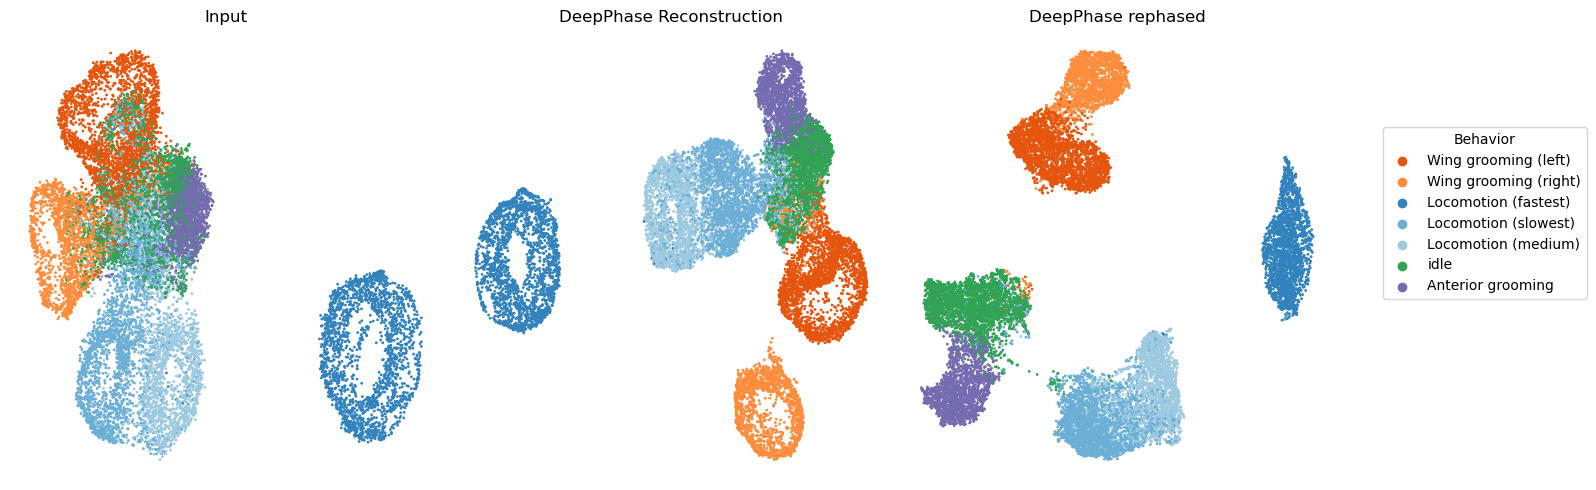

In [11]:
fig, axs = plt.subplots(1, 3, 
                        figsize = (16, 5))

for tnse_lowd, title, ax in zip([umap_input, umap_dp_out, umap_dp_rp], 
                                ["Input", "DeepPhase Reconstruction", "DeepPhase rephased"], 
                                axs.flatten()):
    ax.scatter(x = tnse_lowd[:, 0], y = tnse_lowd[:, 1], s = 1, rasterized = True,
                color = [states_c_dict[i] for i in out_dict['state'].flatten()])
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

for ax in axs.flatten():
    ax.spines[['left', 'right', 'top', 'bottom']].set_visible(False)
    
for key, item in states_c_dict.items():
    axs[-1].scatter([], [], color = item, label = state_dict[key])
axs[-1].legend(title = "Behavior", bbox_to_anchor = (1.1, .8))
# sns.despine()
plt.tight_layout()

plt.savefig(os.path.join(fig_path, "umap_rephase.svg"), 
            dpi = 400, bbox_inches = "tight", format = "svg")

/Genomics/argo/users/tt1131/miniconda3/envs/deepphase/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


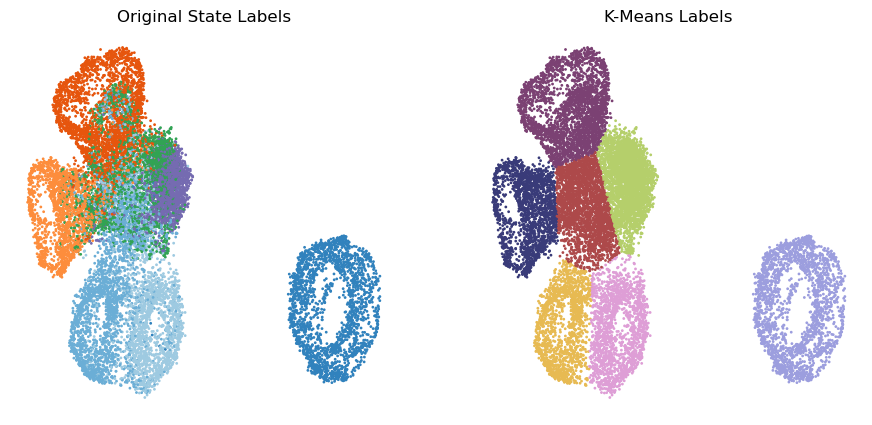

In [14]:
# set the number of clusters
n_clusters = 7

# create a KMeans object with the specified number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
# fit the k-means model to the UMAP-rephased data
kmeans.fit(umap_input)
# get the cluster labels for each data point
in_labels = kmeans.labels_

fig, axs = plt.subplots(1, 2, 
                        figsize=(11, 5),
                        sharex=True, sharey=True)

# plot with original state labels
axs[0].scatter(x=umap_input[:, 0], y=umap_input[:, 1], 
            s = 1, rasterized = True,
            c=[states_c_dict[i] for i in out_dict['state'].flatten()])
axs[0].set_title('Original State Labels')
# plot with k-means labels
axs[1].scatter(x=umap_input[:, 0], y=umap_input[:, 1], 
            s = 1, rasterized = True,
            c=in_labels, cmap='tab20b')
axs[1].set_title('K-Means Labels')

# cmap = cm.tab20b
# for i in np.arange(7):
#     axs[1].scatter([], [], color = cmap(i), label = i + 1)

# axs[1].legend(title = "K-means labels", bbox_to_anchor = (1.1, .8))

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines[['left', 'right', 'top', 'bottom']].set_visible(False)

plt.savefig(os.path.join(fig_path, "umap_original_kmeans.svg"), 
            dpi = 400, bbox_inches = "tight", format = "svg")

In [14]:
kmeans_to_state_dict = {
    3: 1,
    0: 2,
    1: 18,
    6: 16,
    4: 9,
    5: 10,
    2: 7
}

# set the number of clusters
n_clusters = 7

# create a KMeans object with the specified number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
# fit the k-means model to the UMAP-rephased data
kmeans.fit(tsne_dp_rp)
# get the cluster labels for each data point
reph_labels = kmeans.labels_

/Genomics/argo/users/tt1131/miniconda3/envs/deepphase/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


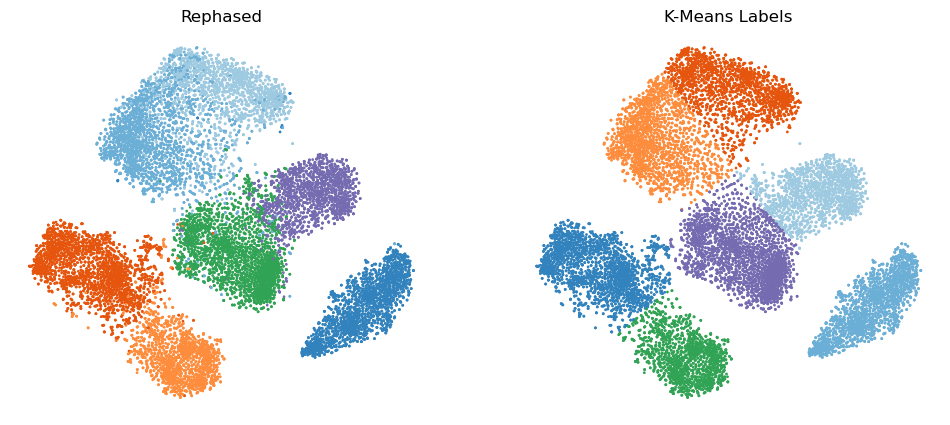

In [15]:
fig, axs = plt.subplots(1, 2, 
                        figsize=(12, 5),
                        sharex=True, sharey=True)

# plot with original state labels
axs[0].scatter(x=tsne_dp_rp[:, 0], y=tsne_dp_rp[:, 1], s = 1, rasterized = True,
            c=[states_c_dict[i] for i in out_dict['state'].flatten()])
axs[0].set_title('Rephased')
# plot with k-means labels
axs[1].scatter(x=tsne_dp_rp[:, 0], y=tsne_dp_rp[:, 1], s = 1, rasterized = True,
            c=[states_c_dict[kmeans_to_state_dict[i]] for i in reph_labels])
axs[1].set_title('K-Means Labels')

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines[['left', 'right', 'top', 'bottom']].set_visible(False)

plt.savefig(os.path.join(fig_path, "tsne_rep_kmeans.svg"), 
            dpi = 400, bbox_inches = "tight", format = "svg")

In [16]:
from sklearn.metrics import silhouette_score

silhouette_rephased = silhouette_score(tsne_dp_rp, reph_labels, metric='euclidean')
silhouette_in= silhouette_score(tsne_dp_rp, in_labels, metric='euclidean')

print(f"Silhouette score of input t-SNE: {silhouette_in}")
print(f"Silhouette score of rephased t-SNE: {silhouette_rephased}")

Silhouette score of input t-SNE: 0.03934898599982262
Silhouette score of rephased t-SNE: 0.5126748085021973


In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

change_idx_dict = {
    1: 0,
    2: 1,
    18: 2,
    16: 3,
    9: 4,
    10: 5,
    7: 6
}

states_desc = ['Wing grooming (left)', 'Wing grooming (right)',
            'Anterior grooming', 'idle', 'Locomotion (slowest)',
            'Locomotion (medium)', 'Locomotion (fastest)']

[0.96740798 0.95835647 0.95070423 0.93666432 0.80267922 0.87447503
 0.99437412] 0.9263801948933736 0.060971227248997104


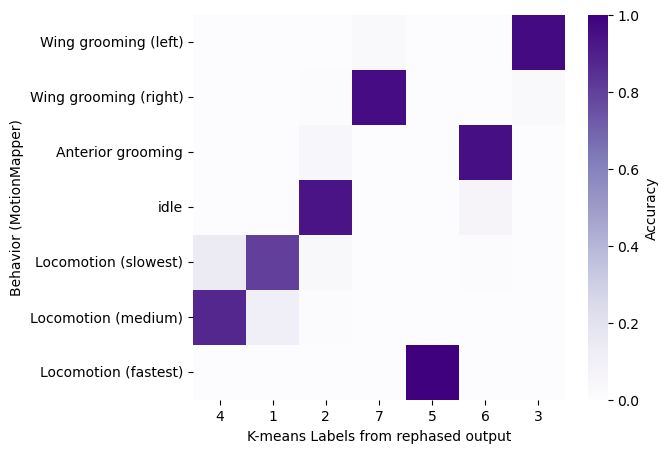

In [30]:
real_labels = out_dict['state'].flatten()
real_labels_encoded = [change_idx_dict[i] for i in real_labels]

# plot the confusion matrices side by side
fig, ax = plt.subplots(figsize=(6, 5))

# plot the confusion matrix for rephased labels
confusion_rephased = confusion_matrix(real_labels_encoded, reph_labels, 
                                    normalize='true')

x_re_idx = np.array([3, 0, 1, 6, 4, 5, 2])
sns.heatmap(confusion_rephased[:, x_re_idx], cmap='Purples',
            vmin = 0, vmax = 1, 
            ax = ax, cbar_kws = {'label': "Accuracy"})

# ax.set_title('Confusion Matrix for Rephased Labels')
ax.set_yticks(np.arange(7) + .5)
ax.set_yticklabels(states_desc, rotation = 0)

ax.set_xticks(np.arange(7) + .5)
ax.set_xticklabels(x_re_idx + 1)

ax.set_ylabel('Behavior (MotionMapper)')
ax.set_xlabel('K-means Labels from rephased output')

max_values_per_row = np.max(confusion_rephased, axis = 1)
print(max_values_per_row, np.mean(max_values_per_row), np.std(max_values_per_row))

# plt.savefig(os.path.join(fig_path, "conf_matrix.svg"), 
#             dpi = 400, bbox_inches = "tight", format = "svg")

/Genomics/argo/users/tt1131/miniconda3/envs/deepphase/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0.94018405 0.96668517 0.90574215 0.85186488 0.67994207 0.85674288
 0.99062353] 0.8845406775348696 0.09654606061758102


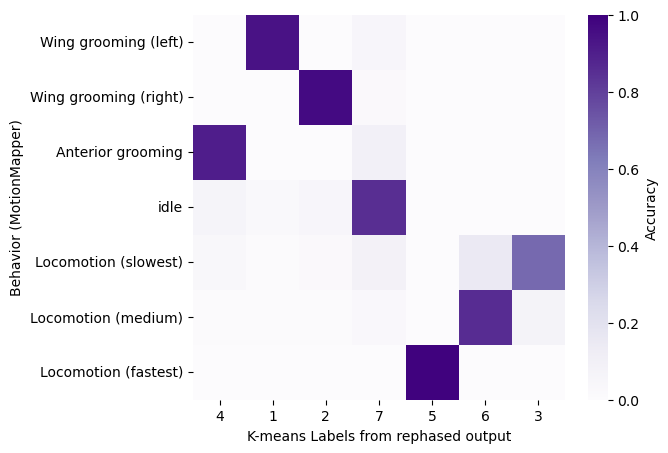

In [31]:
kmeans.fit(tsne_dp_out)
# get the cluster labels for each data point
out_labels = kmeans.labels_

# plot the confusion matrices side by side
fig, ax = plt.subplots(figsize=(6, 5))

# plot the confusion matrix for rephased labels
confusion_out = confusion_matrix(real_labels_encoded, out_labels, normalize='true')

sns.heatmap(confusion_out, cmap='Purples',
            vmin = 0, vmax = 1, 
            ax = ax, cbar_kws = {'label': "Accuracy"})

# ax.set_title('Confusion Matrix for Rephased Labels')
ax.set_yticks(np.arange(7) + .5)
ax.set_yticklabels(states_desc, rotation = 0)

ax.set_xticks(np.arange(7) + .5)
ax.set_xticklabels(x_re_idx + 1)

ax.set_ylabel('Behavior (MotionMapper)')
ax.set_xlabel('K-means Labels from rephased output')

max_values_per_row = np.max(confusion_out, axis = 1)
print(max_values_per_row, np.mean(max_values_per_row), np.std(max_values_per_row))

# plt.savefig(os.path.join(fig_path, "conf_matrix.svg"), 
#             dpi = 400, bbox_inches = "tight", format = "svg")

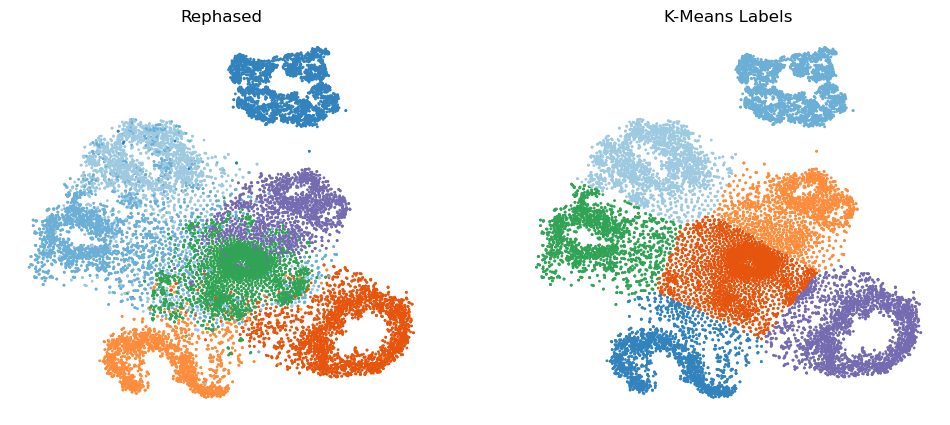

In [24]:
fig, axs = plt.subplots(1, 2, 
                        figsize=(12, 5),
                        sharex=True, sharey=True)

# plot with original state labels
axs[0].scatter(x=tsne_dp_out[:, 0], y=tsne_dp_out[:, 1], s = 1, rasterized = True,
            c=[states_c_dict[i] for i in out_dict['state'].flatten()])
axs[0].set_title('Rephased')
# plot with k-means labels
axs[1].scatter(x=tsne_dp_out[:, 0], y=tsne_dp_out[:, 1], s = 1, rasterized = True,
            c=[states_c_dict[kmeans_to_state_dict[i]] for i in out_labels])
axs[1].set_title('K-Means Labels')

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines[['left', 'right', 'top', 'bottom']].set_visible(False)

plt.savefig(os.path.join(fig_path, "tsne_rep_kmeans.svg"), 
            dpi = 400, bbox_inches = "tight", format = "svg")

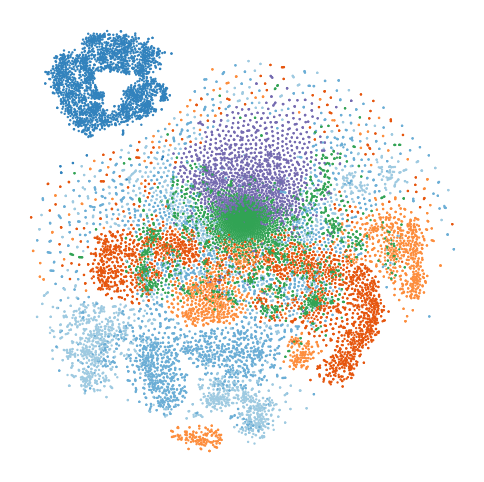

In [18]:
cluster_centers = kmeans.cluster_centers_
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x=tsne_input[:, 0], y=tsne_input[:, 1], 
        c=[states_c_dict[i] for i in out_dict['state'].flatten()], 
        s=.5)

ax.set_xticks([])
ax.set_yticks([])
ax.spines[['left', 'right', 'top', 'bottom']].set_visible(False)

# plt.savefig(os.path.join(fig_path, "inp_tsne"), 
#         bbox_inches = "tight", dpi = 300)

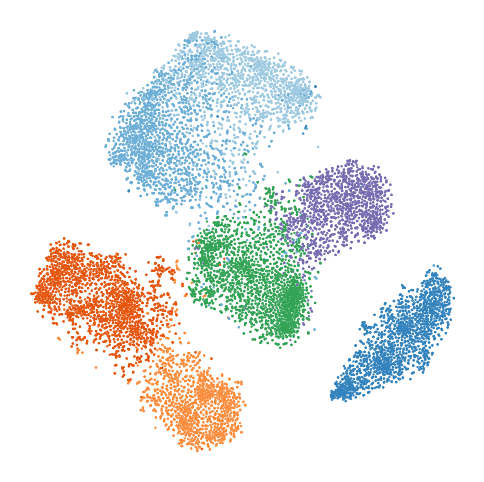

In [19]:
cluster_centers = kmeans.cluster_centers_
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x=tsne_dp_rp[:, 0], y=tsne_dp_rp[:, 1], 
        c=[states_c_dict[i] for i in out_dict['state'].flatten()], 
        s=.5)

ax.set_xticks([])
ax.set_yticks([])
ax.spines[['left', 'right', 'top', 'bottom']].set_visible(False)

# plt.savefig(os.path.join(fig_path, "rep_tsne"), 
#         bbox_inches = "tight", dpi = 300)

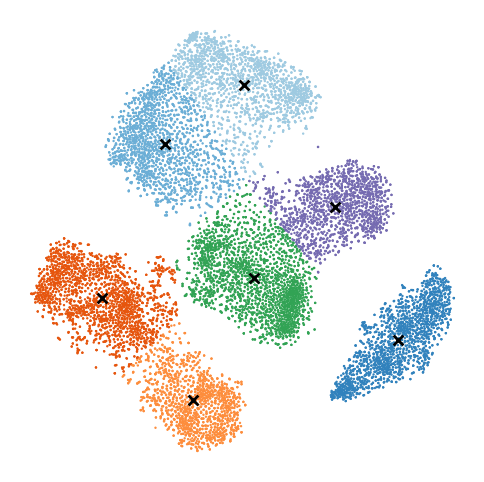

In [20]:
cluster_centers = kmeans.cluster_centers_
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x=tsne_dp_rp[:, 0], y=tsne_dp_rp[:, 1], 
        c=[states_c_dict[kmeans_to_state_dict[i]] for i in reph_labels], 
        s=.5)
ax.scatter(x=cluster_centers[:, 0], y=cluster_centers[:, 1], 
        c='black', s=50, marker='x', lw = 2)
# ax.set_title('K-Means Labels with cluster centers')

ax.set_xticks([])
ax.set_yticks([])
ax.spines[['left', 'right', 'top', 'bottom']].set_visible(False)

# plt.savefig(os.path.join(fig_path, "rep_kmeans_centers"), 
#         bbox_inches = "tight", dpi = 300)

In [21]:
limb_index_dict = {}
for limb in ['Fore', 'Mid', 'Hind']:
    for dir in ['L', 'R']:
        limb_index_dict[f"{limb}_{dir}"] = [np.where(joint_labels == i)[0][0] for i in joint_labels if (limb in i) and (dir in i)]

all_limb_idx = []
for limb in limb_index_dict.values():
    all_limb_idx.extend(limb)

all_limb_idx = np.array(all_limb_idx)
all_limb_idx.sort()

forelimb_indx = [np.where(joint_labels == i)[0][0] for i in joint_labels if ("Fore" in i)]
left_wing_index = 29
right_wing_index = 30

hindlimb_L_indx = [np.where(joint_labels == i)[0][0] for i in joint_labels if ("Hind" in i) and ("L" in i)]
hindlimb_R_indx = [np.where(joint_labels == i)[0][0] for i in joint_labels if ("Hind" in i) and ("R" in i)]

joints_beh_dict = {
    1: np.append(hindlimb_L_indx, left_wing_index),
    2: np.append(hindlimb_R_indx, right_wing_index),
    7: all_limb_idx,
    9: all_limb_idx,
    10: all_limb_idx,
    16: all_limb_idx,
    18: forelimb_indx,
}

In [23]:
from scipy.spatial.distance import cdist

def n_smallest(arr, n):
    """
    Returns the n smallest values and their indices in an array.
    """
    indices = arr.flatten().argsort()[:n]
    return arr[indices], indices

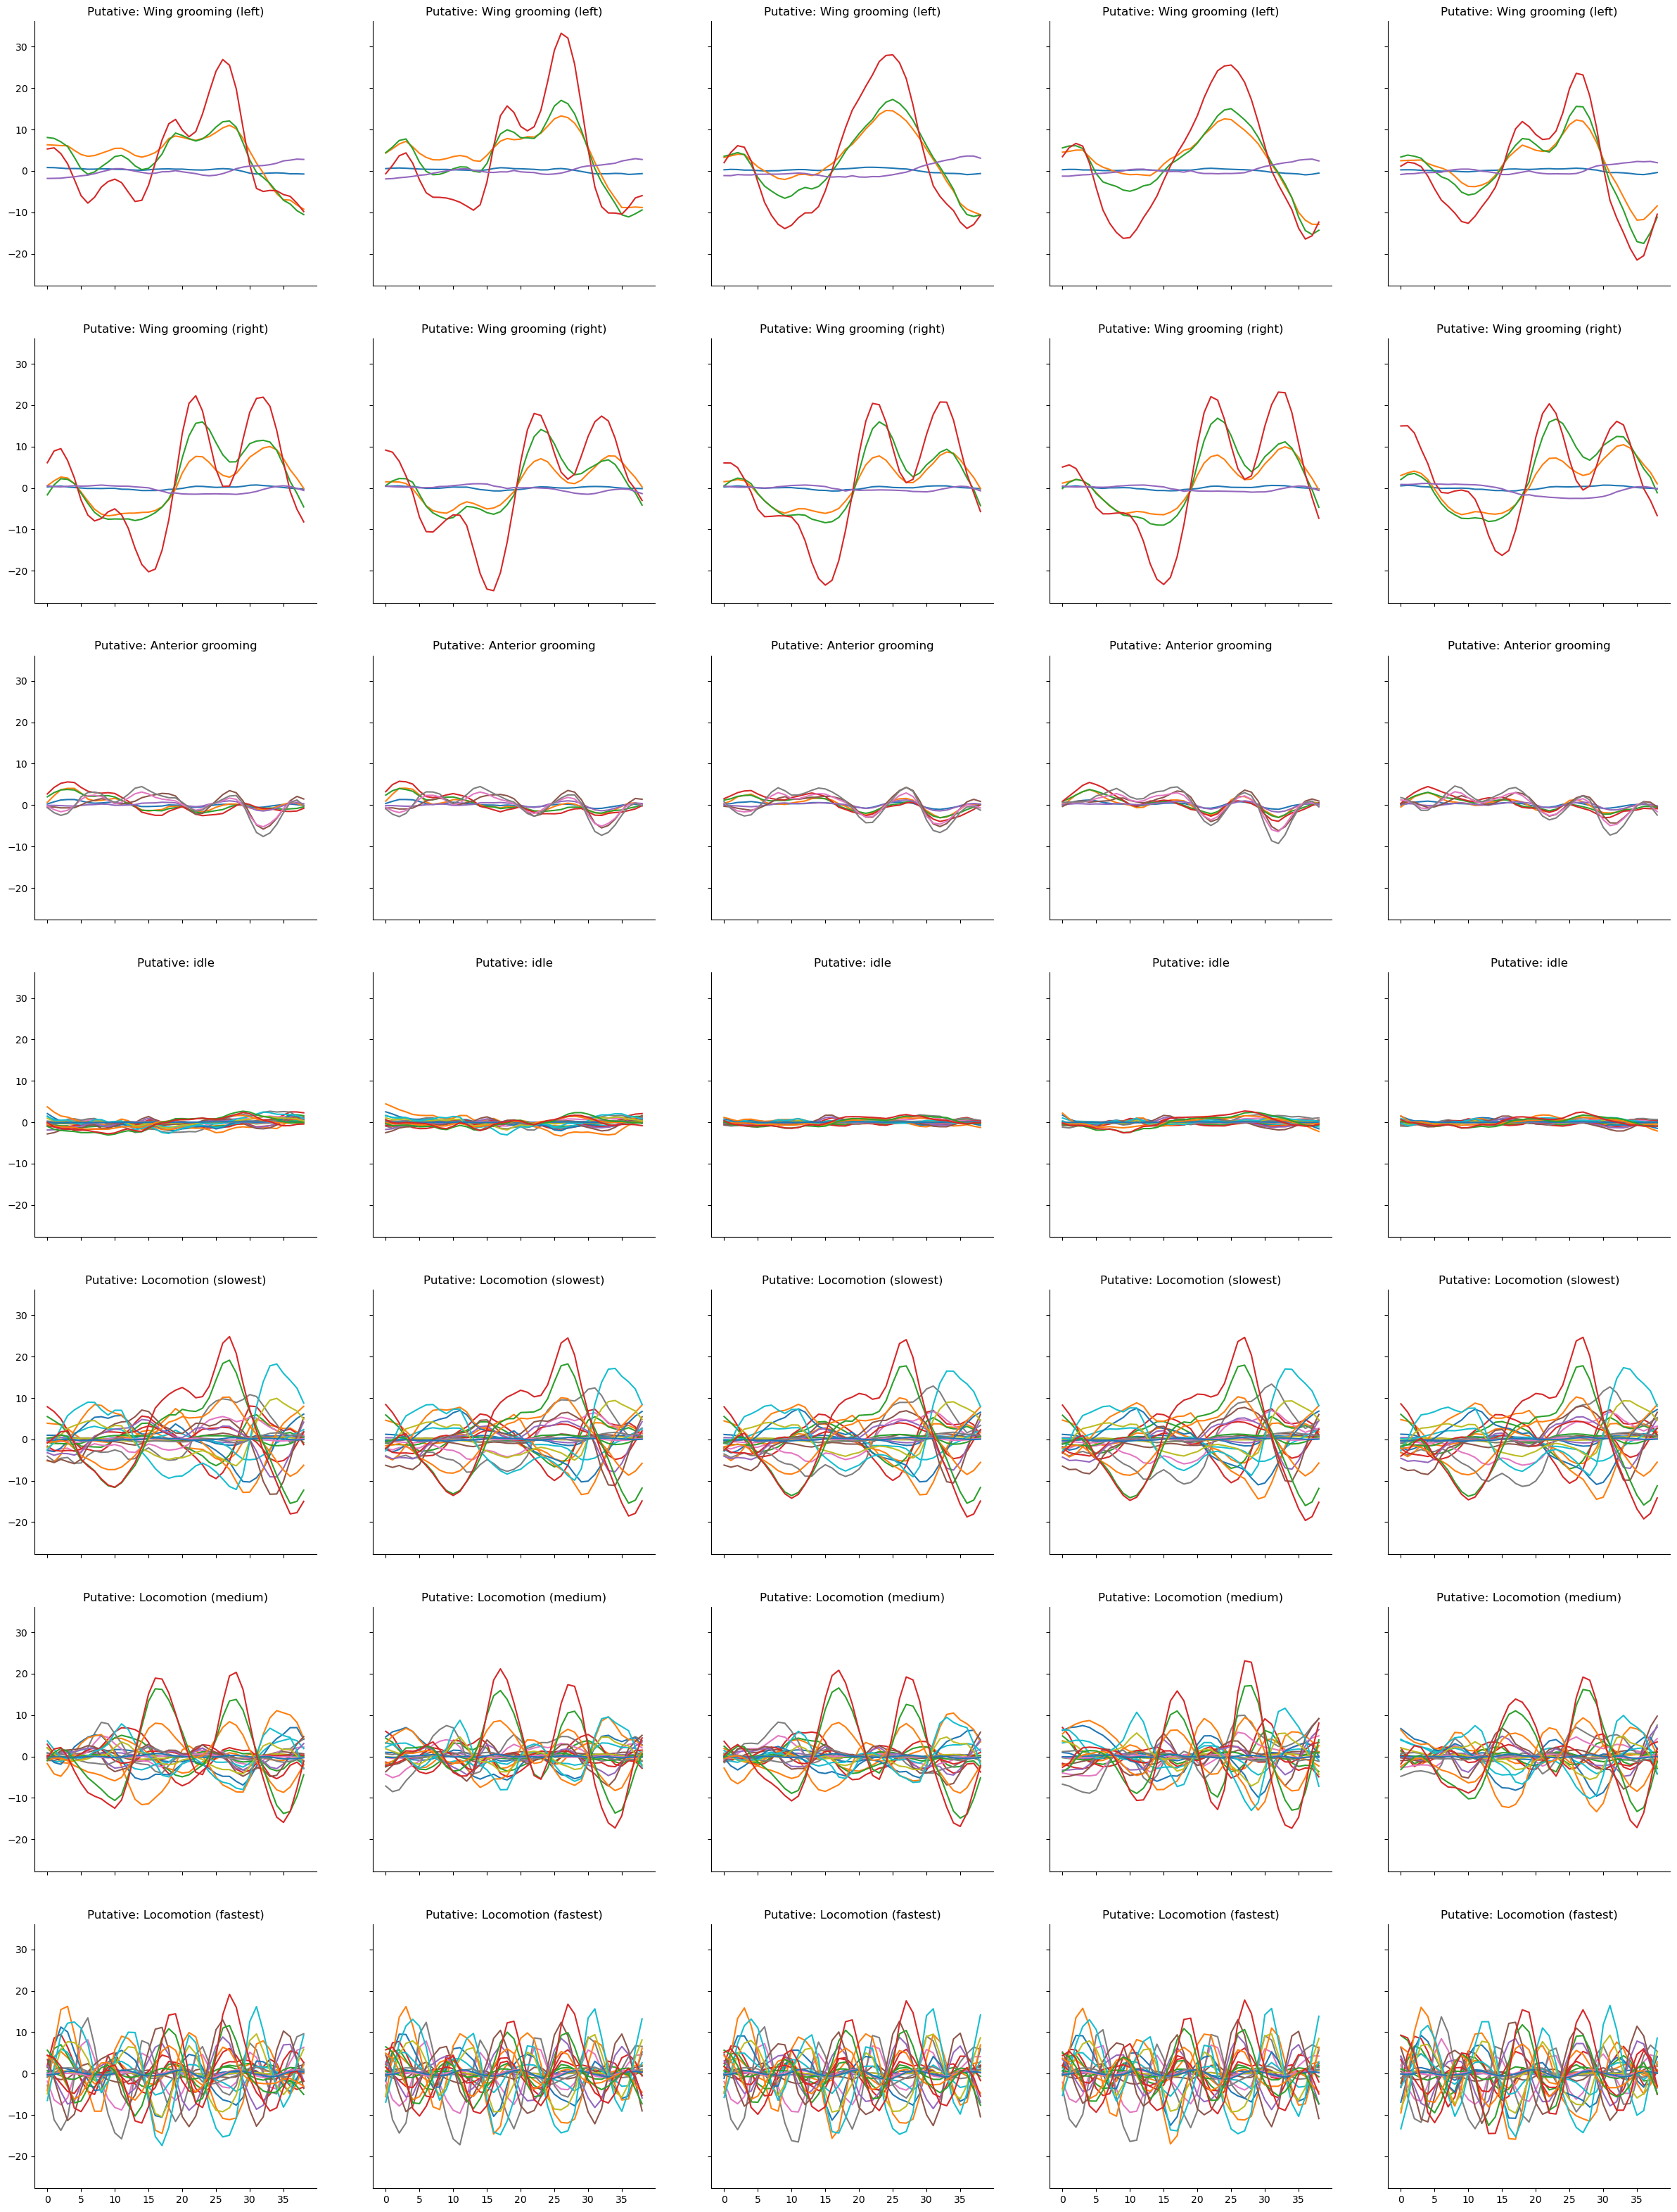

In [199]:
fig, axs = plt.subplots(nrows = 7, ncols = 5, figsize = (30, 40),
                        sharex = True, sharey = True)

for j, (k, v) in enumerate(kmeans_to_state_dict.items()):
    distances = cdist(tsne_dp_rp, cluster_centers[k].reshape(1, -1))
    values, indices = n_smallest(distances, 5)
    beh_segments = rephased_out[indices]

    for i, seg in enumerate(beh_segments):
        seg_ts = rearrange(seg, "t (j d) -> t j d", t = 39, j = 31, d = 2)
        axs[j, i].plot(seg_ts[:, joints_beh_dict[v], 0])
        axs[j, i].set_title(f"Putative: {state_dict[v]}")

sns.despine()

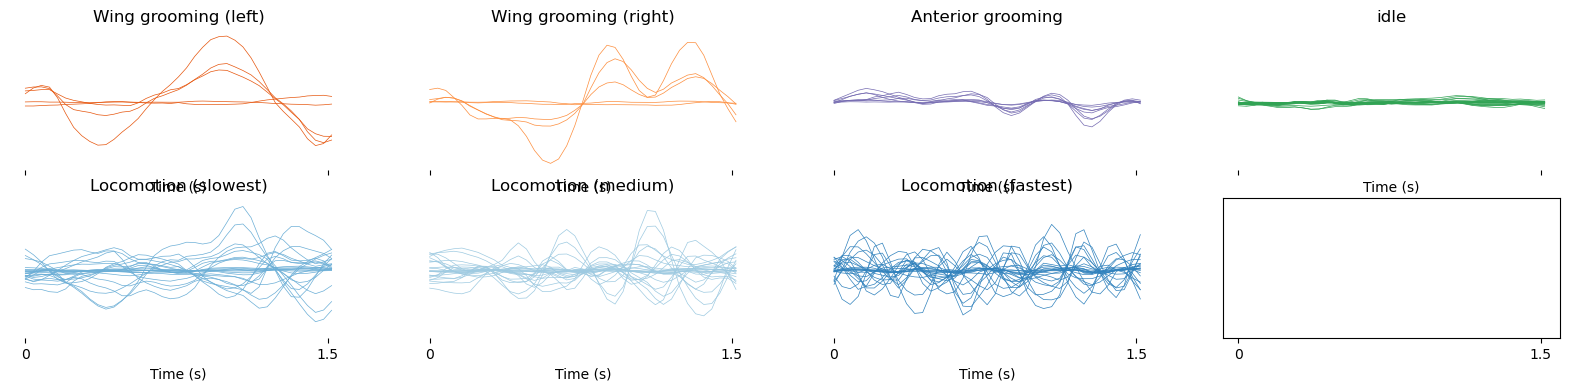

In [30]:
fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (20, 4),
                        sharex = True, sharey = True)

idx = 3

for ax, (k, v) in zip(axs.flatten(), kmeans_to_state_dict.items()):
    distances = cdist(tsne_dp_rp, cluster_centers[k].reshape(1, -1))
    values, indices = n_smallest(distances, 5)
    beh_segments = rephased_out[indices]

    seg = beh_segments[idx]
    seg_ts = rearrange(seg, "t (j d) -> t j d", t = 39, j = 31, d = 2)
    ax.plot(seg_ts[:, joints_beh_dict[v], 0], 
            c = states_c_dict[v], lw = .5)
    ax.set_xticks([0, 37.5])
    ax.set_yticks([])
    ax.set_xticklabels([0, 1.5])
    ax.set_xlabel("Time (s)")
    ax.set_title(f"{state_dict[v]}")
    ## Get rid of spines
    ax.spines[['left', 'right', 'top', 'bottom']].set_visible(False)
    
plt.savefig(os.path.join(fig_path, "putative_centre_color1.svg"), 
            dpi = 400, bbox_inches = "tight", format = "svg")

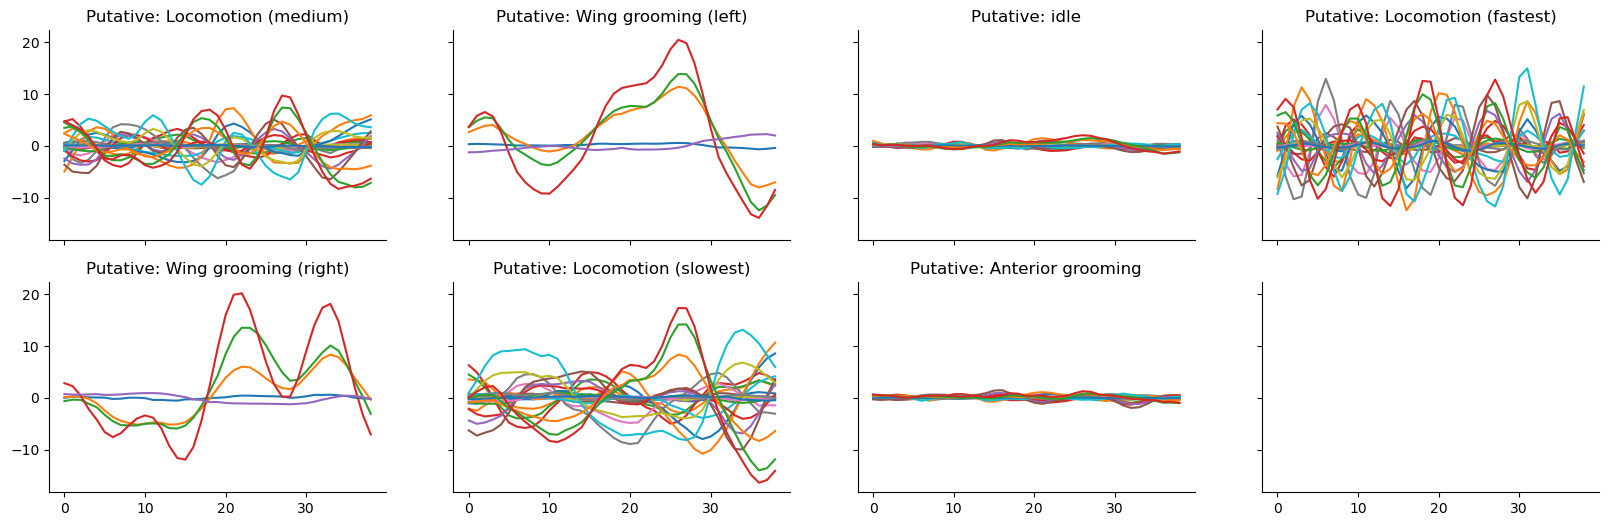

In [ ]:
kmeans_put_idx = [10, 1, 16, 7, 2, 9, 18]

fig, axs = plt.subplots(nrows=2, ncols=4, 
                        figsize=(20, 6), 
                        sharex=True, sharey=True)
for seg, ax, state in zip(cc_segments, axs.flatten(), kmeans_put_idx):
    seg_ts = rearrange(seg, "(t j d) -> t j d", t = 39, j = 31, d = 2)
    ax.plot(seg_ts[:, joints_beh_dict[state], 0])
    ax.set_title(f"Putative: {state_dict[state]}")

sns.despine()

Text(0.5, 0.98, 'Cluster centers with k-means and UMAP')

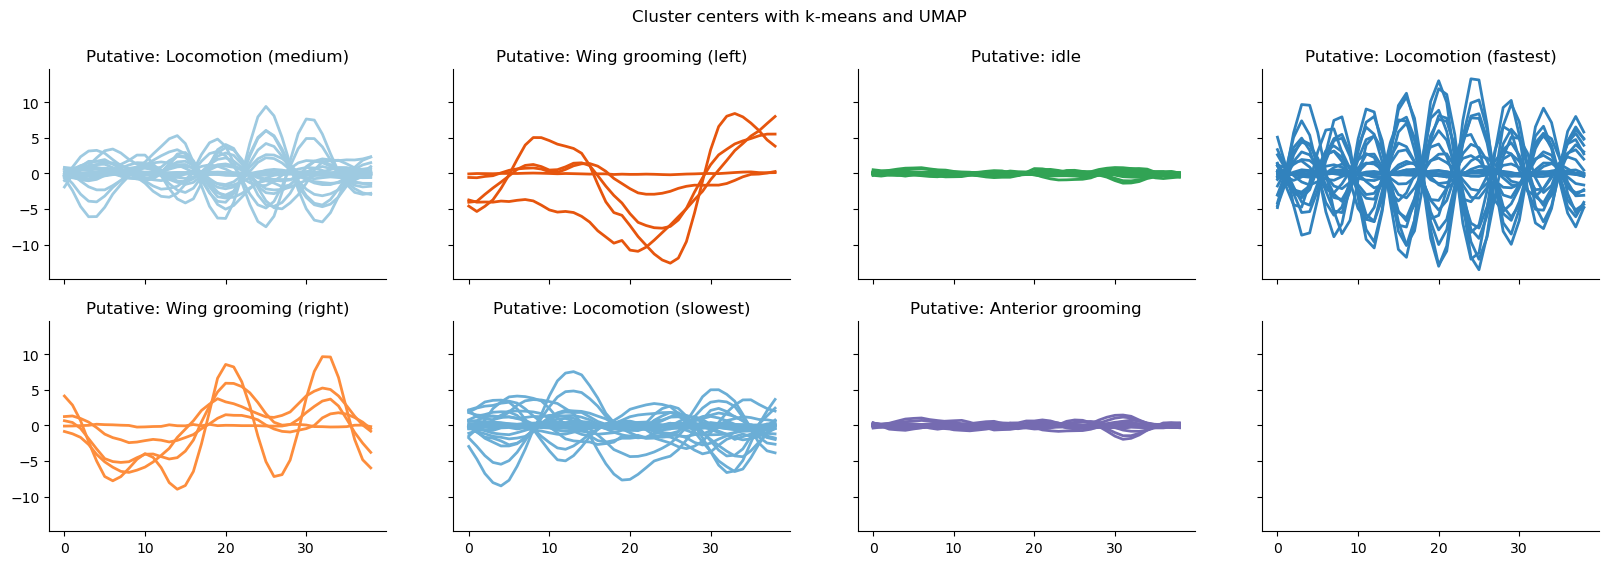

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=4, 
                        figsize=(20, 6), 
                        sharex=True, sharey=True)
for seg, ax, state in zip(cc_segments, axs.flatten(), kmeans_put_idx):
    seg_ts = rearrange(seg, "(t j d) -> t j d", t = 39, j = 31, d = 2)
    ax.plot(seg_ts[:, joints_beh_dict[state], 1], 
            c = states_c_dict[state], lw = 2)
    ax.set_title(f"Putative: {state_dict[state]}")

sns.despine()
plt.suptitle("Cluster centers with k-means and UMAP")

This doesn't seem to work well, sigh

Text(0.5, 0.98, 'Cluster centers with k-means and UMAP')

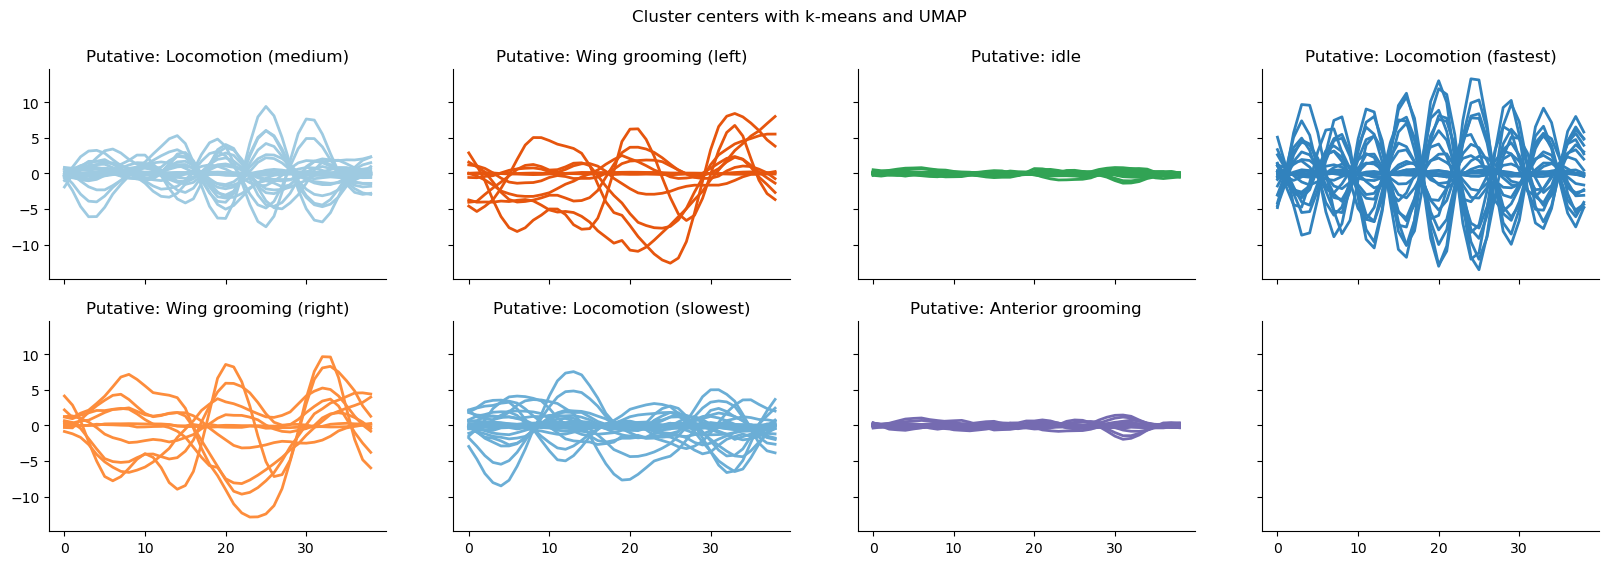

In [ ]:
hindlimb_indx = [np.where(joint_labels == i)[0][0] for i in joint_labels if ("Hind" in i)]

joints_beh_dict = {
    1: np.append(hindlimb_indx, [29, 30]),
    2: np.append(hindlimb_indx, [29, 30]),
    7: all_limb_idx,
    9: all_limb_idx,
    10: all_limb_idx,
    16: all_limb_idx,
    18: all_limb_idx,
}

fig, axs = plt.subplots(nrows=2, ncols=4, 
                        figsize=(20, 6), 
                        sharex=True, sharey=True)
for seg, ax, state in zip(cc_segments, axs.flatten(), kmeans_put_idx):
    seg_ts = rearrange(seg, "(t j d) -> t j d", t = 39, j = 31, d = 2)
    ax.plot(seg_ts[:, joints_beh_dict[state], 1], 
            c = states_c_dict[state], lw = 2)
    ax.set_title(f"Putative: {state_dict[state]}")

sns.despine()
plt.suptitle("Cluster centers with k-means and UMAP")